<a href="https://colab.research.google.com/github/norflin321/ml/blob/main/SDXL_sketch2img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U git+https://github.com/huggingface/diffusers.git controlnet_aux==0.0.7 xformers &> /dev/null
%pip install transformers accelerate safetensors mediapipe invisible_watermark &> /dev/null

from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL, StableDiffusionInstructPix2PixPipeline
from diffusers.utils import load_image, make_image_grid
from controlnet_aux.pidi import PidiNetDetector
import torch
from matplotlib import pyplot as plt
import datetime

# load adapter
adapter = T2IAdapter.from_pretrained("TencentARC/t2i-adapter-sketch-sdxl-1.0", torch_dtype=torch.float16, varient="fp16").to("cuda")

# load euler_a scheduler
euler_a = EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pidinet = PidiNetDetector.from_pretrained("lllyasviel/Annotators").to("cuda")

# load model
pipe = StableDiffusionXLAdapterPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16").to("cuda")
pipe.enable_xformers_memory_efficient_attention()

# prepare sketch image
url = "https://i.imgur.com/HE1TYkx.png"
image = load_image(url)
image = pidinet(image, detect_resolution=1024, image_resolution=1024, apply_filter=True)

  0%|          | 0/50 [00:00<?, ?it/s]

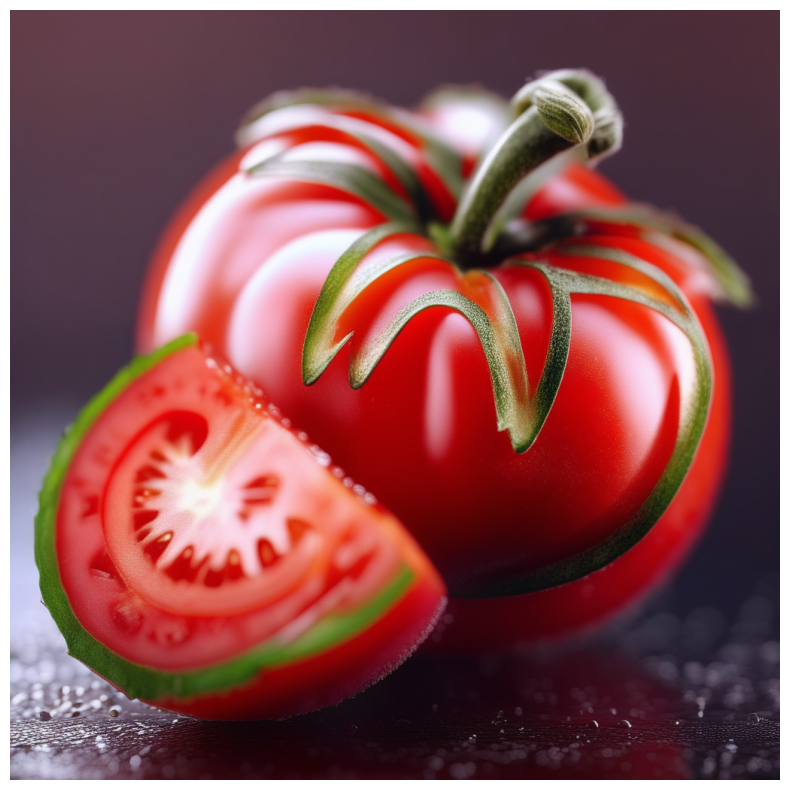

In [3]:
# HYPERPARAMS
prompt = "an extreme closeup shot of a red tomato, 3D, blender, food, 4k graphics, highly detailed, juicy food, sexy,"
negative_prompt = "extra digit, fewer digits, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, disfigured"
steps = 50
guidance = 8
adapter_conditioning_scale = 0.9

# generate
img = pipe(prompt=prompt, negative_prompt=negative_prompt, image=image, num_inference_steps=steps, adapter_conditioning_scale=adapter_conditioning_scale, guidance_scale=guidance).images[0]
time_now = datetime.datetime.now().strftime("%y.%m.%d_%H:%M:%S")
img.save(f"./{time_now}.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()